In [9]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [10]:
train_data_frame=pd.read_csv("dataset/clean_data/train_clean.csv")

In [11]:
test_data_frame=pd.read_csv("dataset/clean_data/test_clean.csv")

In [12]:
class SentimentLSTM:
    def __init__(self, train_df, test_df, tokenizer_function, seq_len, optimizer, vocab_size=5000, batch_sz=32):
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer_function = tokenizer_function
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.optimizer = optimizer
        self.batch_sz = batch_sz
    
    def prepare_sequences(self, texts, is_train=False):
        # Tokenize and pad the input sequences
        if is_train:
            self.tokenizer = self.tokenizer_function(num_words=self.vocab_size, oov_token='<OOV>')
            self.tokenizer.fit_on_texts(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = np.array(pad_sequences(sequences, maxlen=self.seq_len, padding='post', truncating='post'))
        return padded_sequences
    
    def train_model(self, model_type, epochs=10, raw_text=False):
        tf.random.set_seed(42)

        model_config = {
            'xs': (64, 16, 8, 0.2),
            's': (128, 64, 32, 0.2),
            'm': (384, 256, 64, 0.4),
            'l': (768, 384, 128, 0.4)
        }

        if model_type not in model_config:
            print("Please enter a valid model type: xs/s/m/l")
            return

        embed_dim, lstm_cells, dense_cells, dropout_rate = model_config[model_type]

        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.vocab_size, output_dim=embed_dim, input_length=self.seq_len),
            tf.keras.layers.LSTM(lstm_cells, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(dense_cells, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.is_raw = raw_text

        if raw_text:
            train_sequences = self.prepare_sequences(self.train_df['review_content'].tolist(), is_train=True)
        else:
            train_sequences = self.prepare_sequences(self.train_df['clean_text'].tolist(), is_train=True)

        y_train = np.array(self.train_df['sentiment'].map({'pos': 1, 'neg': 0}).tolist())

        # Shuffle the training data
        combined = list(zip(train_sequences, y_train))
        np.random.seed(12)
        np.random.shuffle(combined)
        train_sequences, y_train = zip(*combined)

        train_sequences = np.array(train_sequences)
        y_train = np.array(y_train)

        # Split into training and validation data
        val_samples = int(0.20 * len(train_sequences))
        x_train = train_sequences[:-val_samples]
        y_train_split = y_train[:-val_samples]
        x_val = train_sequences[-val_samples:]
        y_val = y_train[-val_samples:]

        # Early stopping callbacks
        early_stop_acc = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)
        early_stop_loss = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

        # Using a smaller learning rate and gradient clipping
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=5.0)

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train_split, epochs=epochs, batch_size=self.batch_sz, 
                            validation_data=(x_val, y_val), shuffle=False, 
                            callbacks=[early_stop_acc, early_stop_loss])

        if early_stop_acc.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stop_acc.stopped_epoch + 1} (validation accuracy).')
        if early_stop_loss.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stop_loss.stopped_epoch + 1} (validation loss).')

        self.model = model
        self.train_acc = history.history['accuracy']
        self.val_acc = history.history['val_accuracy']
        self.train_loss = history.history['loss']
        self.val_loss = history.history['val_loss']

        # Save the trained model
        model.save(f'data/LSTM_models/{model_type}_epochs_{epochs}_{self.vocab_size}_{self.seq_len}_adam_{raw_text}.keras')

    def evaluate(self):
        if self.is_raw:
            test_sequences = self.prepare_sequences(self.test_df['review_content'].tolist(), is_train=False)
        else:
            test_sequences = self.prepare_sequences(self.test_df['clean_text'].tolist(), is_train=False)

        y_test = np.array(self.test_df['sentiment'].map({'pos': 1, 'neg': 0}).tolist())
        predictions = self.model.predict(test_sequences)
        binary_preds = [1 if pred > 0.5 else 0 for pred in predictions]

        accuracy = accuracy_score(y_test, binary_preds)
        print("Accuracy (LSTM):", accuracy)

        conf_matrix = confusion_matrix(y_test, binary_preds)
        print("Confusion Matrix (LSTM):\n", conf_matrix)

        class_report = classification_report(y_test, binary_preds)
        print("Classification Report (LSTM):\n", class_report)


In [13]:
import matplotlib.pyplot as plt

def plot_training_validation_accuracy(model_trainer):
    # Plotting Training and Validation Accuracy
    epoch_range = range(1, len(model_trainer.train_acc) + 1)
    
    # Plot the training accuracy
    plt.plot(epoch_range, model_trainer.train_acc, color='blue', label='Training Accuracy')
    
    # Plot the validation accuracy
    plt.plot(epoch_range, model_trainer.val_acc, color='red', label='Validation Accuracy')
    
    # Customize ticks for the x-axis
    plt.xticks(epoch_range)
    
    # Set the title and labels for the plot
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()

def plot_training_validation_loss(model_trainer):
    # Plotting Training and Validation Loss
    epoch_range = range(1, len(model_trainer.train_loss) + 1)
    
    # Plot the training loss
    plt.plot(epoch_range, model_trainer.train_loss, color='blue', label='Training Loss')
    
    # Plot the validation loss
    plt.plot(epoch_range, model_trainer.val_loss, color='red', label='Validation Loss')
    
    # Customize ticks for the x-axis
    plt.xticks(epoch_range)
    
    # Set the title and labels for the plot
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()


In [14]:
def train_LSTM(num_words, max_length, learning_rate, batch_size, model_size, epochs, use_raw_text):
    # Create an instance of SentimentLSTM class
    model_trainer = SentimentLSTM(
        train_df=train_data_frame,  # Replace with your actual train DataFrame
        test_df=test_data_frame,  # Replace with your actual test DataFrame
        tokenizer_function=Tokenizer,  # Replace with your tokenizer function
        seq_len=max_length,  # Sequence length
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Optimizer with learning rate
        vocab_size=num_words,  # Vocabulary size
        batch_sz=batch_size  # Batch size
    )
    
    # Train the model
    model_trainer.train_model(
        model_type=model_size,  # Model size ('xs', 's', 'm', 'l')
        epochs=epochs,  # Number of epochs
        raw_text=use_raw_text  # Whether to use raw text or preprocessed text
    )
    
    # Print model summary
    model_trainer.model.summary()
    
    # Evaluate the model
    model_trainer.evaluate()

    return model_trainer


In [15]:
# Parameters
num_words = 500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)


C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 34s 704ms/step - accuracy: 0.6138 - loss: 0.6486 - val_accuracy: 0.7756 - val_loss: 0.6433
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 642ms/step - accuracy: 0.7997 - loss: 0.4416 - val_accuracy: 0.8182 - val_loss: 0.6353
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 486ms/step - accuracy: 0.8216 - loss: 0.4038 - val_accuracy: 0.8016 - val_loss: 0.6199
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 626ms/step - accuracy: 0.8254 - loss: 0.3975 - val_accuracy: 0.7920 - val_loss: 0.6114
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 128)            │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 346,821 (1.32 MB)

 Trainable params: 115,585 (451.50 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 231,172 (903.02 KB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step
Accuracy (LSTM): 0.78708
Confusion Matrix (LSTM):
 [[11621   879]
 [ 4444  8056]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.72      0.93      0.81     12500
           1       0.90      0.64      0.75     12500

    accuracy                           0.79     25000
   macro avg       0.81      0.79      0.78     25000
weighted avg       0.81      0.79      0.78     25000



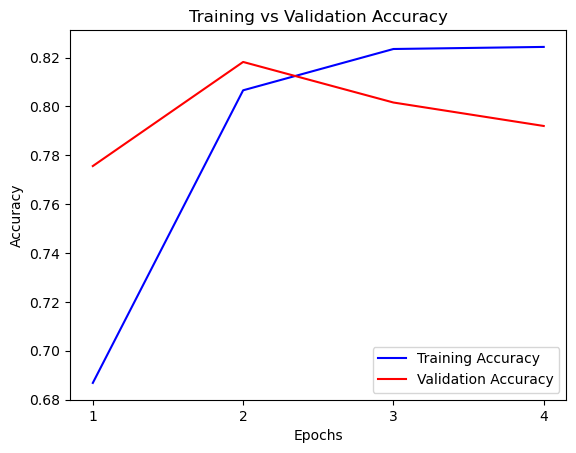

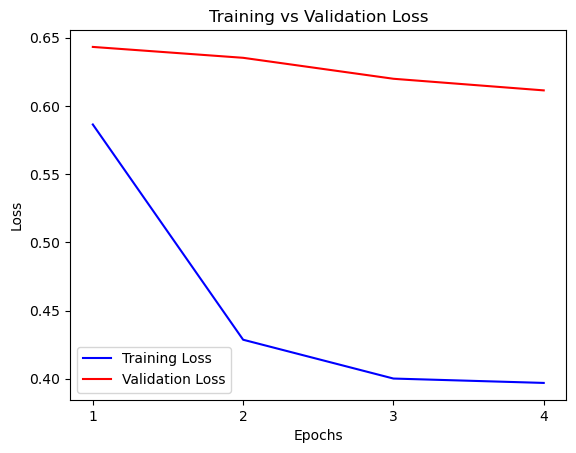

In [16]:
plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 722ms/step - accuracy: 0.6515 - loss: 0.6148 - val_accuracy: 0.6740 - val_loss: 0.6529
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 693ms/step - accuracy: 0.8268 - loss: 0.3981 - val_accuracy: 0.8320 - val_loss: 0.6338
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 658ms/step - accuracy: 0.8429 - loss: 0.3688 - val_accuracy: 0.8206 - val_loss: 0.6193
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 687ms/step - accuracy: 0.8407 - loss: 0.3633 - val_accuracy: 0.8256 - val_loss: 0.6042
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 150, 128)            │          96,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 150, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 442,821 (1.69 MB)

 Trainable params: 147,585 (576.50 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 295,172 (1.13 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step
Accuracy (LSTM): 0.82368
Confusion Matrix (LSTM):
 [[11302  1198]
 [ 3210  9290]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.78      0.90      0.84     12500
           1       0.89      0.74      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



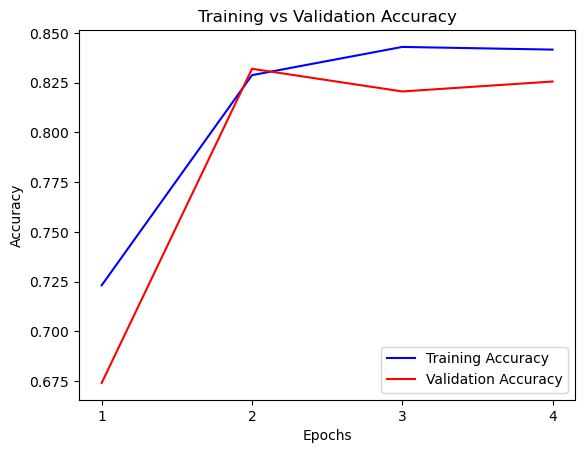

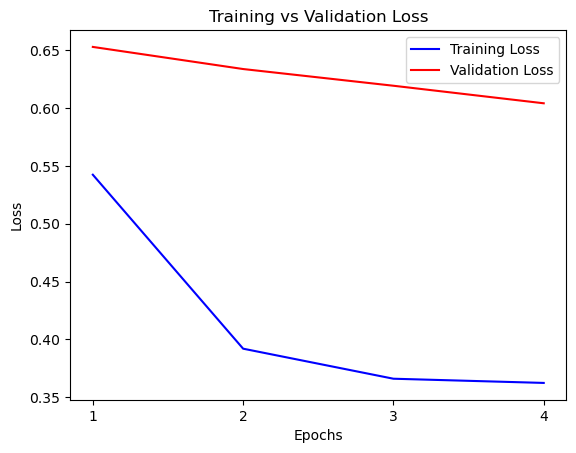

In [17]:
# Parameters
num_words = 750  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - accuracy: 0.6649 - loss: 0.6116 - val_accuracy: 0.8114 - val_loss: 0.6480
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.8320 - loss: 0.3813 - val_accuracy: 0.8202 - val_loss: 0.6270
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 484ms/step - accuracy: 0.8474 - loss: 0.3551 - val_accuracy: 0.7516 - val_loss: 0.6202
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 524ms/step - accuracy: 0.8538 - loss: 0.3387 - val_accuracy: 0.7584 - val_loss: 0.6011
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 150, 128)            │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 150, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,821 (2.06 MB)

 Trainable params: 179,585 (701.50 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 359,172 (1.37 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
Accuracy (LSTM): 0.75392
Confusion Matrix (LSTM):
 [[12074   426]
 [ 5726  6774]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.68      0.97      0.80     12500
           1       0.94      0.54      0.69     12500

    accuracy                           0.75     25000
   macro avg       0.81      0.75      0.74     25000
weighted avg       0.81      0.75      0.74     25000



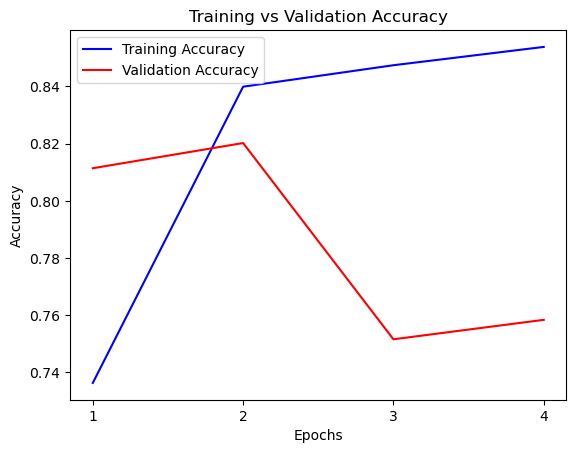

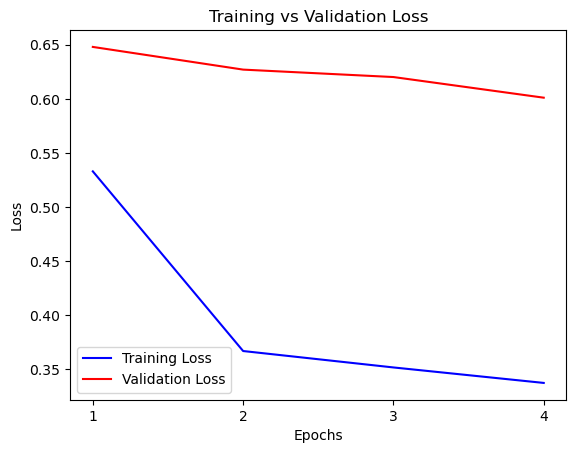

In [18]:
# Parameters
num_words = 1000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 's'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6158 - loss: 0.6604 - val_accuracy: 0.7780 - val_loss: 0.6332
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8477 - loss: 0.3615 - val_accuracy: 0.7762 - val_loss: 0.5939
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8762 - loss: 0.3030 - val_accuracy: 0.8314 - val_loss: 0.5501
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.8863 - loss: 0.2811 - val_accuracy: 0.8574 - val_loss: 0.5278
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.8888 - loss: 0.2688 - val_accuracy: 0.8446 - val_loss: 0.4872
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.8872 - loss: 0.2751 - val_accuracy: 0.8494 - val_loss: 0.4318
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
Restoring model weights from the end of the best epoch: 6.
Early stopping occurred at epoch 6 (validation accuracy).


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 150, 384)            │         960,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 150, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,899,205 (18.69 MB)

 Trainable params: 1,633,025 (6.23 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 3,266,052 (12.46 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 135ms/step
Accuracy (LSTM): 0.844
Confusion Matrix (LSTM):
 [[10919  1581]
 [ 2319 10181]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.82      0.87      0.85     12500
           1       0.87      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



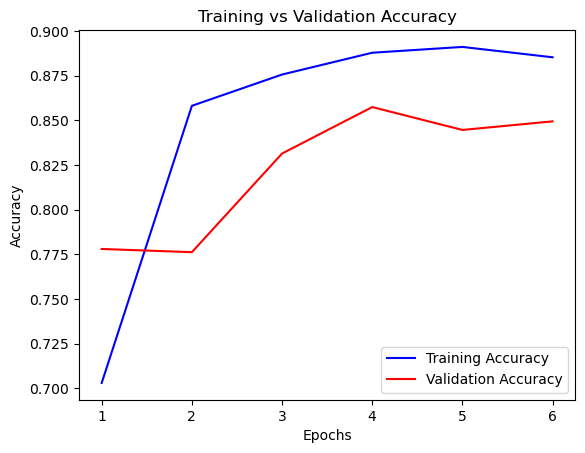

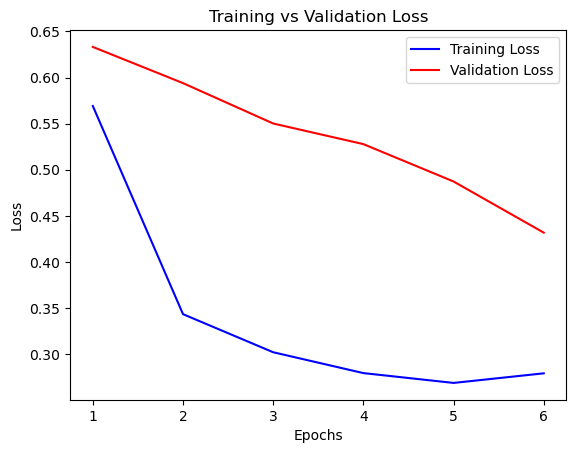

In [19]:
# Parameters
num_words = 2500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.6368 - loss: 0.6149 - val_accuracy: 0.8334 - val_loss: 0.6357
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.8751 - loss: 0.3055 - val_accuracy: 0.8066 - val_loss: 0.6134
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.8795 - loss: 0.2873 - val_accuracy: 0.8684 - val_loss: 0.5635
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9082 - loss: 0.2329 - val_accuracy: 0.8560 - val_loss: 0.5140
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9192 - loss: 0.2089 - val_accuracy: 0.8374 - val_loss: 0.4926
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
Restoring model weights from the end of the best epoch: 5.
Early stopping occurred at epoch 5 (validation accuracy).


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 150, 384)            │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,779,205 (29.68 MB)

 Trainable params: 2,593,025 (9.89 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 5,186,052 (19.78 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step
Accuracy (LSTM): 0.81984
Confusion Matrix (LSTM):
 [[ 8967  3533]
 [  971 11529]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.90      0.72      0.80     12500
           1       0.77      0.92      0.84     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



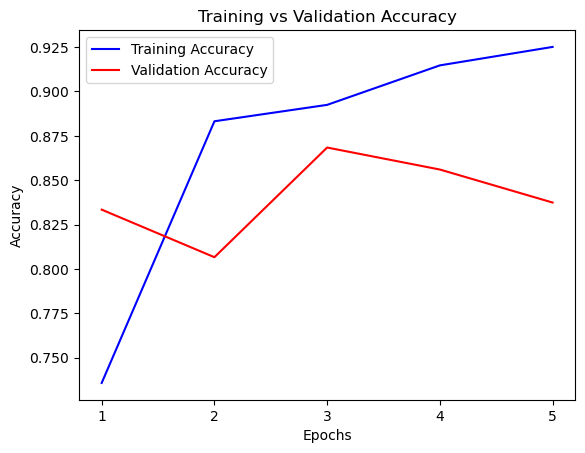

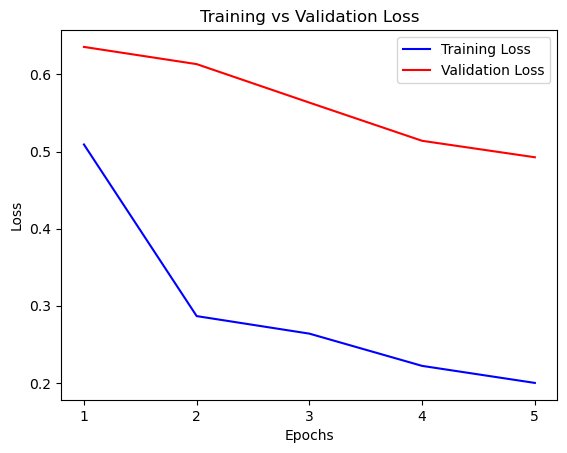

In [20]:
# Parameters
num_words = 5000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6356 - loss: 0.6239 - val_accuracy: 0.7862 - val_loss: 0.6420
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8728 - loss: 0.3055 - val_accuracy: 0.8710 - val_loss: 0.5837
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9036 - loss: 0.2411 - val_accuracy: 0.8724 - val_loss: 0.5474
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9226 - loss: 0.2027 - val_accuracy: 0.8640 - val_loss: 0.5118
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.9338 - loss: 0.1795 - val_accuracy: 0.8382 - val_loss: 0.4457
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
Restoring model weights from the end of the best epoch: 5.
Early stopping occurred at epoch 5 (validation accuracy).


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 150, 384)            │       2,880,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 150, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,659,205 (40.66 MB)

 Trainable params: 3,553,025 (13.55 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 7,106,052 (27.11 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step
Accuracy (LSTM): 0.81992
Confusion Matrix (LSTM):
 [[ 9425  3075]
 [ 1427 11073]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.87      0.75      0.81     12500
           1       0.78      0.89      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



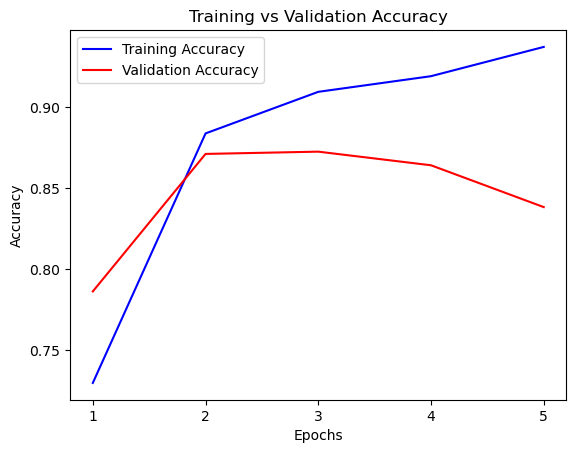

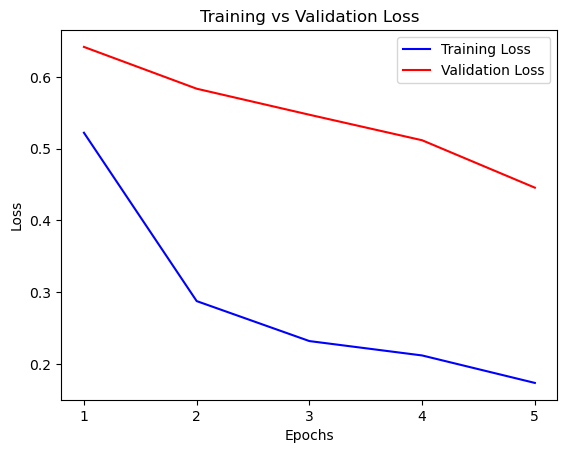

In [21]:
# Parameters
num_words = 7500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 100  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.6801 - loss: 0.5847 - val_accuracy: 0.8134 - val_loss: 0.6526
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8653 - loss: 0.3199 - val_accuracy: 0.8388 - val_loss: 0.6206
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9028 - loss: 0.2437 - val_accuracy: 0.8358 - val_loss: 0.5797
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.9247 - loss: 0.1984 - val_accuracy: 0.8060 - val_loss: 0.5563
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 150, 384)            │       2,880,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 150, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,659,205 (40.66 MB)

 Trainable params: 3,553,025 (13.55 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 7,106,052 (27.11 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step
Accuracy (LSTM): 0.80136
Confusion Matrix (LSTM):
 [[ 8577  3923]
 [ 1043 11457]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.89      0.69      0.78     12500
           1       0.74      0.92      0.82     12500

    accuracy                           0.80     25000
   macro avg       0.82      0.80      0.80     25000
weighted avg       0.82      0.80      0.80     25000



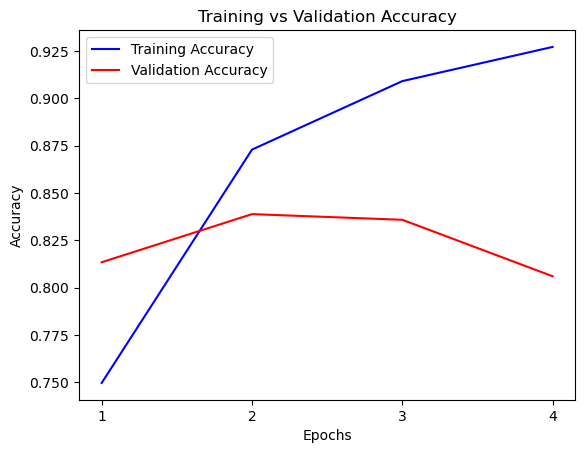

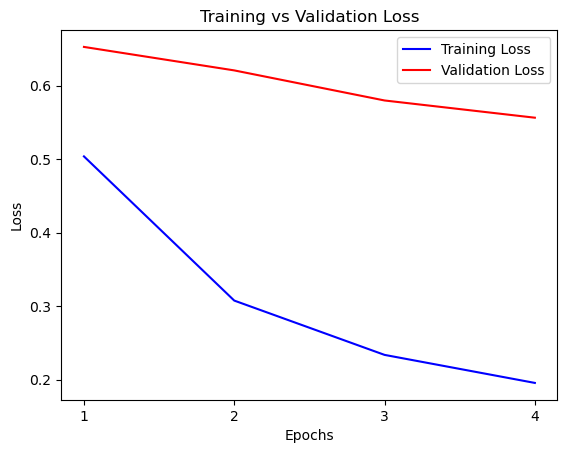

In [22]:
# Parameters
num_words = 7500  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'm'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - accuracy: 0.6288 - loss: 0.6390 - val_accuracy: 0.8202 - val_loss: 0.6361
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 244s 6s/step - accuracy: 0.8703 - loss: 0.3037 - val_accuracy: 0.8666 - val_loss: 0.5748
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.9203 - loss: 0.2081 - val_accuracy: 0.7860 - val_loss: 0.5231
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - accuracy: 0.9369 - loss: 0.1641 - val_accuracy: 0.7972 - val_loss: 0.4645
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 150, 768)            │       7,680,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 150, 384)            │       1,771,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 384)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,502,277 (108.73 MB)

 Trainable params: 9,500,673 (36.24 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 19,001,348 (72.48 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 201ms/step
Accuracy (LSTM): 0.77168
Confusion Matrix (LSTM):
 [[ 7556  4944]
 [  764 11736]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.91      0.60      0.73     12500
           1       0.70      0.94      0.80     12500

    accuracy                           0.77     25000
   macro avg       0.81      0.77      0.77     25000
weighted avg       0.81      0.77      0.77     25000



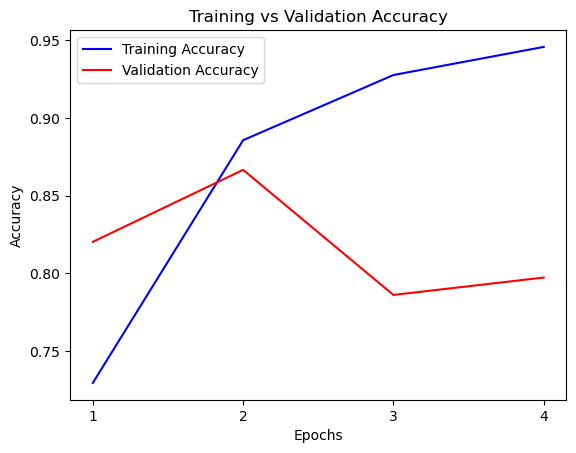

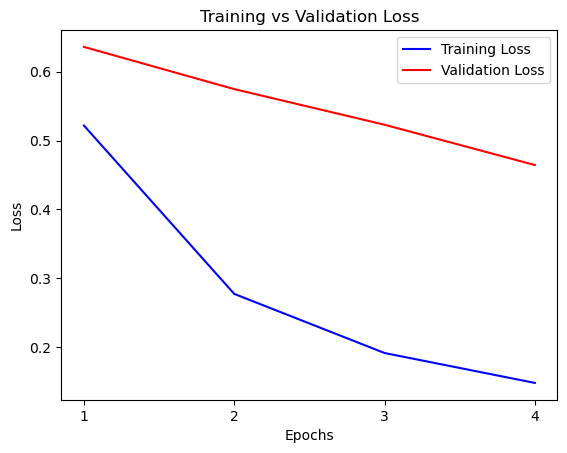

In [23]:
# Parameters
num_words = 10000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'l'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 265s 7s/step - accuracy: 0.6790 - loss: 0.5766 - val_accuracy: 0.7900 - val_loss: 0.6536
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 260s 6s/step - accuracy: 0.8782 - loss: 0.2914 - val_accuracy: 0.8420 - val_loss: 0.6095
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - accuracy: 0.9107 - loss: 0.2229 - val_accuracy: 0.7872 - val_loss: 0.5586
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.9302 - loss: 0.1808 - val_accuracy: 0.8324 - val_loss: 0.5188
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 4 (validation accuracy).


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 150, 768)            │       7,680,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 150, 384)            │       1,771,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_9           │ (None, 384)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,502,277 (108.73 MB)

 Trainable params: 9,500,673 (36.24 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 19,001,348 (72.48 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 156s 198ms/step
Accuracy (LSTM): 0.8058
Confusion Matrix (LSTM):
 [[10074  2426]
 [ 2429 10071]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     12500
           1       0.81      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



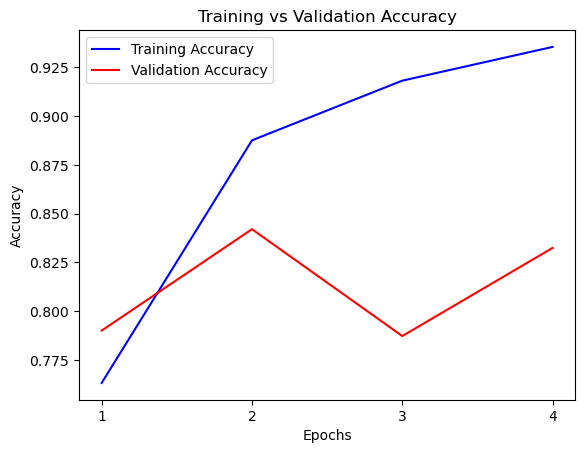

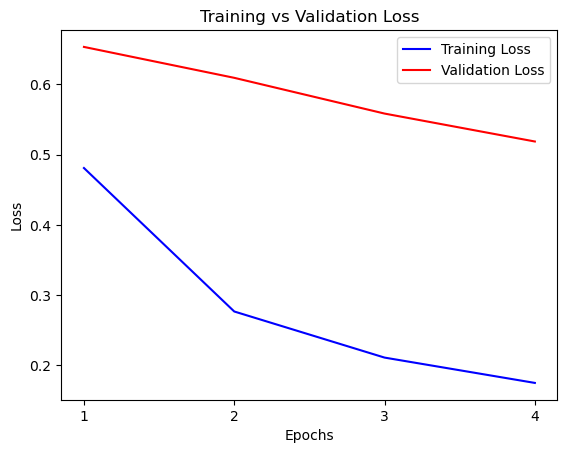

In [24]:
# Parameters
num_words = 10000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 512  # Batch size
model_size = 'l'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.6865 - loss: 0.5598 - val_accuracy: 0.8396 - val_loss: 0.6040
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 366s 4s/step - accuracy: 0.9013 - loss: 0.2458 - val_accuracy: 0.8184 - val_loss: 0.5465
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.9440 - loss: 0.1528 - val_accuracy: 0.8374 - val_loss: 0.4303
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 3.
Early stopping occurred at epoch 3 (validation accuracy).


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 150, 768)            │      15,360,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 150, 384)            │       1,771,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_10          │ (None, 384)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,542,277 (196.62 MB)

 Trainable params: 17,180,673 (65.54 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,361,348 (131.08 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 175s 223ms/step
Accuracy (LSTM): 0.80108
Confusion Matrix (LSTM):
 [[ 9320  3180]
 [ 1793 10707]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.84      0.75      0.79     12500
           1       0.77      0.86      0.81     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



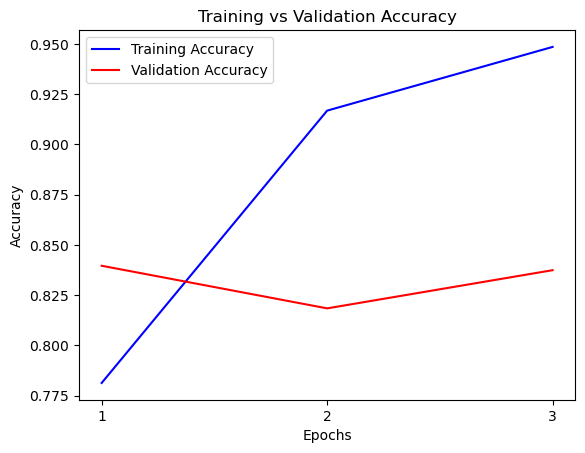

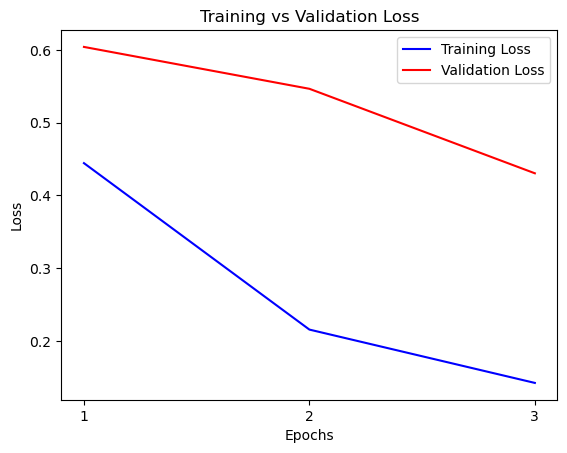

In [25]:
# Parameters
num_words = 20000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 256  # Batch size
model_size = 'l'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = False  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)

C:\Users\tejas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.7047 - loss: 0.5436 - val_accuracy: 0.8244 - val_loss: 0.6350
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 402s 5s/step - accuracy: 0.9019 - loss: 0.2476 - val_accuracy: 0.8150 - val_loss: 0.5577
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 512s 6s/step - accuracy: 0.9417 - loss: 0.1598 - val_accuracy: 0.8272 - val_loss: 0.5147
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.9677 - loss: 0.0961 - val_accuracy: 0.8348 - val_loss: 0.3943
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.9775 - loss: 0.0680 - val_accuracy: 0.8188 - val_loss: 0.4116
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.9819 - loss: 0.0548 - val_accuracy: 0.8066 - val_loss: 0.5019
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.
Early stopping occurred at epoch 6 (validation accuracy).
Early stopping

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 150, 768)            │      15,360,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 150, 384)            │       1,771,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_11          │ (None, 384)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,542,277 (196.62 MB)

 Trainable params: 17,180,673 (65.54 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 34,361,348 (131.08 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 298s 380ms/step
Accuracy (LSTM): 0.80912
Confusion Matrix (LSTM):
 [[10173  2327]
 [ 2445 10055]]
Classification Report (LSTM):
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     12500
           1       0.81      0.80      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



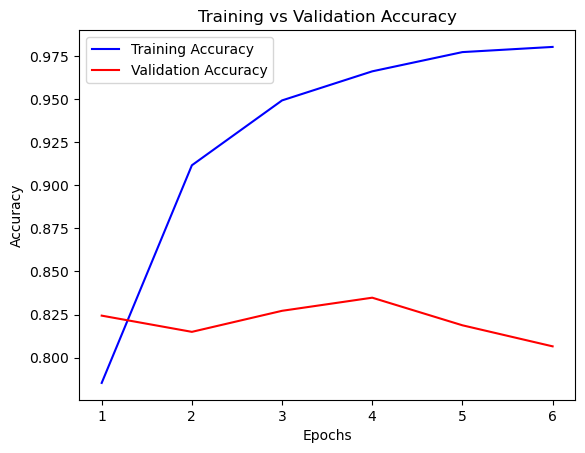

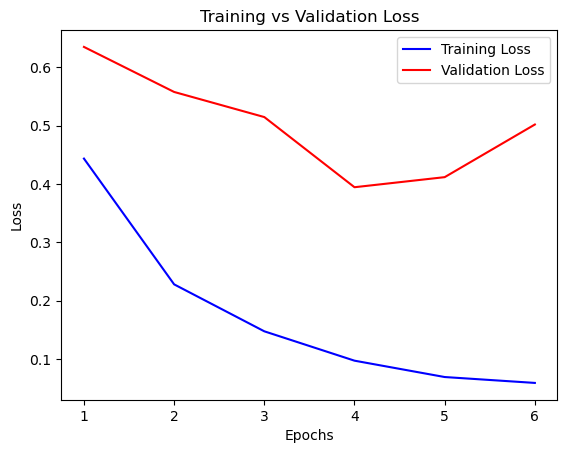

In [26]:
# Parameters
num_words = 20000  # Maximum vocabulary size
max_len = 150  # Maximum sequence length
learning_rate = 0.003  # Learning rate for optimizer
epochs = 10  # Number of training epochs
batch_size = 256  # Batch size
model_size = 'l'  # Model size ('xs', 's', 'm', 'l')
use_raw_text = True  # Whether to use raw or preprocessed text

# Train the model
trained_model = train_LSTM(
    num_words=num_words,
    max_length=max_len,
    learning_rate=learning_rate,
    batch_size=batch_size,
    model_size=model_size,
    epochs=epochs,
    use_raw_text=use_raw_text
)

plot_training_validation_accuracy(trained_model)
plot_training_validation_loss(trained_model)